# Function inversion with Grover's algorithm

In this notebook, we will illustrate how to inverse functions with Grover's algorithm.

_Note_ : Grover's algorithm itself will not be detailled in this notebook.
For more information about it, see the other notebook.

The problem we want to solve is:
> Given a function $f$ and a value $y$ such that it exists a $x$ such that $y = f(x)$, find x.

In general, solving this problem roughly comes down to function inversion, namely finding a function $f^{-1}$ such that $x = f^{-1}(y)$.

In this notebook, we will inverse the addition of two bits and a carry.
This function was detailled in another notebook.

To do so, we need to define another function $g$ such that $g(x) = 1$ if $f(x) = y$, $g(x) = 0$ otherwise.
Now, finding $x$ such that $f(x) = y$ is equivalent to finding $x$ such that $g(x) = 1$.

In classical computing, we could implement the addition and g like this:
```python
def add(carry, x, y):
    """
    Adds carry, x, y. Returns the sum and the next carry.
    
    carry, x, y: 0 or 1
    return: (sum, next carry) = (0 or 1, 0 or 1)
    """
    s = carry + x + y
    next_carry = s >> 1
    s = s & 1
    return (s, next_carry)

def g(carry, x, y):
    """
    Tests if add(carry, x, y) is equal to a hardcoded value.
    
    return: 0 or 1
    """
    return 1 if (add(carry, x, y) == (hard_coded_s, hard_coded_next_carry)) else 0
```

In [1]:
%matplotlib inline
# Import Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram
from math import pi, ceil, sqrt

## Definition of the functions

We first need to implement the $f$ function with a quantum circuit.

We use the same implementation of the addition as we did in the previous notebook.

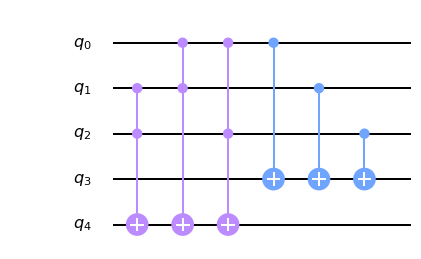

In [2]:
# 0: c, 1: x, 2: y, 3: sum (init to |0>), 4: nextC (init to |0>)
add_circuit = QuantumCircuit(5, name='add')
add_circuit.toffoli(1, 2, 4)
add_circuit.toffoli(0, 1, 4)
add_circuit.toffoli(0, 2, 4)
add_circuit.cnot(0, 3)
add_circuit.cnot(1, 3)
add_circuit.cnot(2, 3)
add_circuit.draw()

Then, we need to define $g$, but to do so, we first need to choose $y$.

In this notebook, we set `hard_coded_s=1` and `hard_coded_next_carry=0`.
This way, we will find all the antededents `carry, x, y` such that `add(carry, x, y) == (1, 0)` by finding all the antecedents of 1 by `g`.

Let us implement `g` as a quantum circuit.

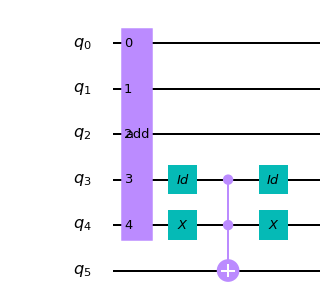

In [3]:
g_circuit = QuantumCircuit(add_circuit.n_qubits + 1, name='g')
# "+1" because g needs one more qubit than add for its output
g_circuit.append(add_circuit.to_instruction(), range(add_circuit.n_qubits))
g_circuit.iden(3) # sum == 1
g_circuit.x(4)    # next_carry == 0
g_circuit.toffoli(3, 4, 5) # flip the value of the last qubit if sum == 1 and next_carry == 0
g_circuit.iden(3)
g_circuit.x(4)
g_circuit.draw()

## Definition of the oracle Uf

Now that we have our function to inverse, namely $g$, we must build an oracle that will flip the phase of a state if the output of $g$ is 1.

To do so, we first apply $g$ to the register.
Then, we apply a Z gate to the output of $g$.
This way, if the bit was flipped (from |0> to |1>) its phase will be flipped by the Z gate.
Finally, to clear the mess we made by applying $g$, we apply all the gates of $g$ in reverse order.
In the end, only the phase flip remains.

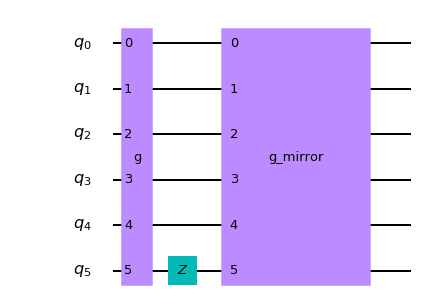

In [4]:
oracle_circuit = QuantumCircuit(g_circuit.n_qubits, name='Uf')
oracle_circuit.append(g_circuit.to_instruction(), range(g_circuit.n_qubits))
oracle_circuit.z(g_circuit.n_qubits - 1)
oracle_circuit.append(g_circuit.mirror().to_instruction(), range(g_circuit.n_qubits))
oracle_circuit.draw()

## Grover's Algorithm

Grover's search algorithm will not be explained in this notebook, refer to the other one for explainations.

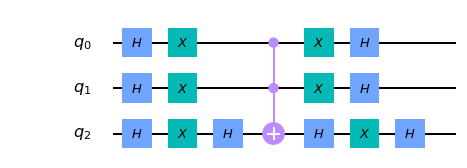

In [5]:
# The diffusion operator Us
# It is only applied to the first three qubits of the register
# because we only look for the values of the inputs
us_circuit = QuantumCircuit(3, name='Us')
us_circuit.h(range(3))
us_circuit.x(range(3))
us_circuit.h(2)         # CCZ(0, 1, 2)
us_circuit.ccx(0, 1, 2) # CCZ(0, 1, 2)
us_circuit.h(2)         # CCZ(0, 1, 2)
us_circuit.x(range(3))
us_circuit.h(range(3))

us_circuit.draw()

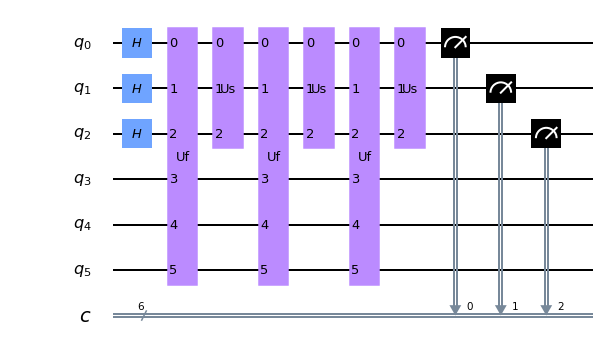

In [6]:
# Grover's algorithm circuit
grover_n_qubits = max(oracle_circuit.n_qubits, us_circuit.n_qubits)
grover_circuit = QuantumCircuit(grover_n_qubits, grover_n_qubits)
grover_circuit.h(range(us_circuit.n_qubits))
for _ in range(ceil(pi/4 * sqrt(2**us_circuit.n_qubits))):
    grover_circuit.append(oracle_circuit.to_instruction(), range(oracle_circuit.n_qubits))
    grover_circuit.append(us_circuit.to_instruction(), range(us_circuit.n_qubits))
grover_circuit.measure(range(us_circuit.n_qubits), range(us_circuit.n_qubits))
grover_circuit.draw()

## Execution of the algorithm

Let us simulate our circuit.

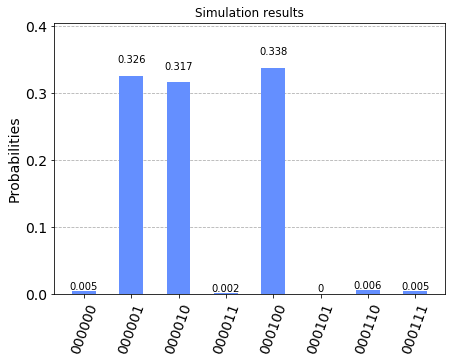

In [7]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(grover_circuit, backend=simulator, shots=1024)
grover_counts = job.result().get_counts(grover_circuit)
plot_histogram(grover_counts, title='Simulation results')

## Conclusion

As we can see, three elements are frequently measured: `001`, `010` and `100`.
These outputs correspond to `carry, x, y`, so the interpretation of our results is the following:
> To have a sum of 1 and a next carry of 0 when adding two bits and a carry, the inputs must be either:
> * carry=1, x=0, y=0
> * carry=0, x=1, y=0
> * carry=0, x=0, y=1

We can quickly check that $1+0+0=1$, $0+1+0=1$ and $0+0+1=1$.

So, we managed to find the antecedents of a given image by a function.
We could apply the same method to find the antecedents of all couples of bits `(sum, next_carry)` (4 cases) of the addition function and, consequently, inverse the addition.

Furthermore, we could use Grover's algorithm to find the antecedents of any image by any function.
With a powerful enough quantum computer, one could:
* find antecedents of digests by hash functions
* find antecedents of cipher messages by symmetric cipher algorithms
* ...